In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import math
from google.colab import drive

This dataset contains information on medical procedures, the state, city, zip code, and facility where the procedure was done and the average covered charges, average patient payment and average medicare payment for that procedure. This data set includes information on a vast array of procedures and the aforementioned fields.
There are 3 specific fields of interests.
‘Average Covered Charges’ : the average insurer payout for a given procedure
‘Average Total Payments’: the average a patient pays out of pocket for a procedure
‘Average Medicare Payment’: the average medicare pays out for a given procedure.


The purpose of this research is to ascertain if there is a significant difference in the average patient cost for a permanent pacemaker in the two states that have the highest number of those procedures performed. 
There is one null hypothesis and one alternative hypothesis: 

No = There is no significant difference in the average price of the installation of a permanent pacemaker in the two states where that procedure is done the most

Na = There is a significant difference in the average price of the installation of a permanent pacemaker in the two states where that procedure is done the most.

These hypotheses will be tested on the three fields, Average Covered Charges, Average Total Payments, Average Medicare Payments

This hypothesis is interesting to healthcare professionals, insurance companies and consumers themselves as it shows whether or not there is a significant difference for the same treatment across states that engage in that procedure the most. Underlying conclusions could be that one state has generally better healthcare than the other, however this might not be the case if the two states engage in the procedure more than any other state. 

The stakeholders this information will be useful for: Insurance companies, Hospitals and Consumers. In the United States heart disease is the number one killer of adults over the age of 40 and pacemaker installations are one of the most common procedures done in order to prevent death from heart disease. This being a procedure that is widely done, and one that helps millions of Americans have longer healthier lives, many groups should have interest in the average price of the procedure in the two states that perform the procedure the most. Insurers would like to know how their plans are working and what is the average insurer payout, patients would like to know what is the average patient cost, and the government would have interest in the average medicare payout. Hospitals should have access to all this information.

In [2]:
#Read Data, and examine attributes
data = pd.read_csv('https://data.cms.gov/api/views/97k6-zzx3/rows.csv?accessType=DOWNLOAD')
data.info()
data.head()

# Split Data into two states, New York and Florida, and narrow all the procedures
# down to pacemaker installations
data_fl = data[data['Provider State'] == 'FL']
data_ny = data[data['Provider State'] == 'NY']
pacemaker_fl = data_fl[data_fl['DRG Definition'] == '243 - PERMANENT CARDIAC PACEMAKER IMPLANT W CC']
pacemaker_ny = data_ny[data_ny['DRG Definition'] == '243 - PERMANENT CARDIAC PACEMAKER IMPLANT W CC']
data.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   DRG Definition                        163065 non-null  object 
 1   Provider Id                           163065 non-null  int64  
 2   Provider Name                         163065 non-null  object 
 3   Provider Street Address               163065 non-null  object 
 4   Provider City                         163065 non-null  object 
 5   Provider State                        163065 non-null  object 
 6   Provider Zip Code                     163065 non-null  int64  
 7   Hospital Referral Region Description  163065 non-null  object 
 8    Total Discharges                     163065 non-null  int64  
 9    Average Covered Charges              163065 non-null  float64
 10   Average Total Payments               163065 non-null  float64
 11  

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44


Below we have the functions that will be utilized to test our data and create visualizations.

In [0]:
#Function that test the normality of two sets fo data, visually and with
#stats.shapiro and stats.describe
def test_normal(data_set_1, data_set_2, data_parameter):
  hist1 = plt.hist(data_set_1[data_parameter], alpha = .5)
  hist2 = plt.hist(data_set_2[data_parameter], alpha = .5)
  plt.axvline(data_set_1[data_parameter].mean(), color = 'green')
  plt.axvline(data_set_2[data_parameter].mean(), color = 'blue')
  plt.xlabel('Blue = Florida\nOrange = New York')
  plt.ylabel('Number of Cases')
  plt.title('Distribution of Average Costs')
  plt.show()
  print('The statistics for Florida are: {}'.format(stats.describe(data_set_1[data_parameter])))
  print('The statistics for New York are: {}'.format(stats.describe(data_set_2[data_parameter])))
  print('Shaprio test for Florida data: {}'.format(stats.shapiro(data_set_1[data_parameter])))
  print('Shapiro test for New York data: {}'.format(stats.shapiro(data_set_2[data_parameter])))

# If tests show signficant difference, this will cacluate the difference with
# a 95% confidicne interval
def confidence_interval(array_1, array_2):
  sample_1_n = array_1.shape[0]
  sample_2_n = array_2.shape[0]
  sample_1_mean = array_1.mean()
  sample_2_mean = array_2.mean()
  sample_1_var = array_1.var()
  sample_2_var = array_2.var()
  mean_difference = sample_2_mean - sample_1_mean
  std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
  margin_of_error = 1.96 * std_err_difference
  ci_lower = mean_difference - margin_of_error
  ci_upper = mean_difference + margin_of_error
  return [ci_lower, ci_upper]

# Function that visualizes the average differnce in cost if there is one
def bar_chart(x_bar, data, title, y_label, cgi):
  if cgi[0] < 0:
    cgi[0] = -cgi[0]
  if cgi[1] < 0:
    cgi[1] = -cgi[1]
  plt.bar(x = x_bar, height=[data[0], data[1]])
  plt.ylabel(y_label)
  plt.title(title)
  plt.axhline(cgi[0], label = 'Max Differnce')
  plt.axhline(cgi[1], label = 'Min Difference')
  plt.show()
  



Below we have the first test, on the 'Average Covered Charges' or the charges paid out by the insurance companies for the installation of permanent pacemakers, in the states of Florida and New York. We will test if there a differnce in average of what each state charges, on average, for the procedure.

Before the test can be preformed, we must first establish if the data sets are average or not. This is vital as it tells us what type of test needs to be preformed. This particular test has both New York and Florida with normal data sets, meaning that there are no significant outliers (extremely high or low prices for the procedure) and the data sets can be tested normally. Also, while Florida has a significantly higher number of procedures preformed (Florida 91, New York 56), the prices seem to be in a reasonalbe, non-erratic range.

Also based on simple visualization and the descriptive statistics, Florida not only has many more cases than New York, the max insurer payout for Florida 
(128,000) is quite a bit higher than the max price for New York, (106,000).

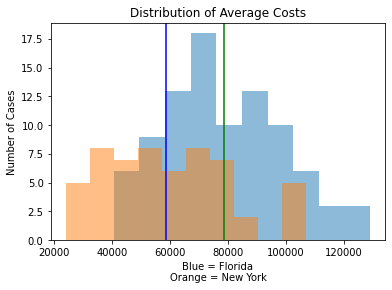

The statistics for Florida are: DescribeResult(nobs=91, minmax=(40617.64, 128929.52), mean=78576.34043956043, variance=413632254.0868932, skewness=0.3232001006170604, kurtosis=-0.5680366918240729)
The statistics for New York are: DescribeResult(nobs=56, minmax=(24082.25, 106714.78), mean=58700.272678571426, variance=448401280.25559455, skewness=0.549372677728344, kurtosis=-0.3701868522248484)
Shaprio test for Florida data: (0.9771147966384888, 0.10913373529911041)
Shapiro test for New York data: (0.9548407196998596, 0.03517498821020126)

The Shapiro test and the visual both show that the Average Covered Charges variables for New York and Florida are normal.
These averages can be compared using a standard ttest. 



In [4]:
# Prefrom tests on 'Average Covered Charges' normality
test_normal(pacemaker_fl, pacemaker_ny, " Average Covered Charges ")

# Results of Normality Tests
'''
As we can see from the test_normal function both data sets are 'normal'. This means
that a basic ttest can show us whethere there is a significant differnce in the averages of the data sets.
Notice that the kurtosis and skew are within a reasonable range, and the p-values from the shapiro tests on New York and Florida
are .03 and .01 respectively, meaning we can be certain that our data sets are normal.
'''
print('\nThe Shapiro test and the visual both show that the Average Covered Charges variables for New York and Florida are normal.')
print('These averages can be compared using a standard ttest. \n')



Below we have the results of the ttest between Florida and New York, for the Average Covered Charges, paid out by the insurer. According to our ttest, there is almost certainly a difference in the average insurer payout between the two states, as our test statistic is 31.56, much higher than the indicated critical statistic of 1.86. Also the p-value is almost 0, a decimal with 213 zeroes, essentially nothing. Therefore we can be certain there is a significant differnce. We then calcualte what this differnce could be, and we find that the average differnce in insurer payout between Florida and New York for a pacemaker installation is somewhere between 26820 and 12931, with 95% confidence. 

For better visualization we have plotted the average insurer payout for the two states and what range the difference would be in for both states. 

With this test complete we can reject our null hypothesis. We conclude that the althernative hypothesis is true, and that there is a significant difference.

Ttest_indResult(statistic=31.564978763224055, pvalue=1.5587583526452542e-213)

Based on the ttest we see that there is almost certainly a significant difference.
The difference in means at the 95% confidence interval (two-tail) is between -26820.272000579072 and -12931.863521398966.


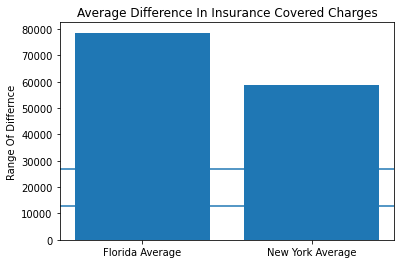

In [5]:
#Results of T-test on Florida and New York for Average Covered Chareges ('Insurer Payout')
print(stats.ttest_ind(data_fl[' Average Covered Charges '], data_ny[' Average Covered Charges ']))
print('\nBased on the ttest we see that there is almost certainly a significant difference.')
ci_avg_covered = confidence_interval(pacemaker_fl[' Average Covered Charges '], pacemaker_ny[' Average Covered Charges '])
print("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_avg_covered[0])+" and "+str(ci_avg_covered[1])+".")
x_bar = ['Florida Average', 'New York Average']
bar_chart(x_bar,[pacemaker_fl[' Average Covered Charges '].mean(), pacemaker_ny[' Average Covered Charges '].mean()], 'Average Difference In Insurance Covered Charges', 'Range Of Differnce', ci_avg_covered)


Below we have the second test, on the 'Average Total Payments' or the charges paid by the patient for the installation of permanent pacemakers, in the states of Florida and New York. We will test if there a differnce in average of what each state charges, on average, for the procedure.

Before the test can be preformed, we must first establish if the data sets are average or not. This is vital as it tells us what type of test needs to be preformed. This particular test has Florida with a non-normal distribution, and New York with a normal distribution. It would seem that when it comes to what the patient payments, Florida's distributions are quite skewed to lower values, as opposed to New York's which are more normally distributed. Florida in particular has a powerful skew towards lower patient payments, with thier patients paying as low as 13,000 while New York patients can pay as low as 14,000 but could pay up to 32,000 much higher than Florida's max of 28,000. Florida's patient payments are not only generally lower, but also a larger number of patients in Florida pay lower prices with an average patient payment of 16,000 while New York patients pay over a wider spread, with an average payment of 21,000.

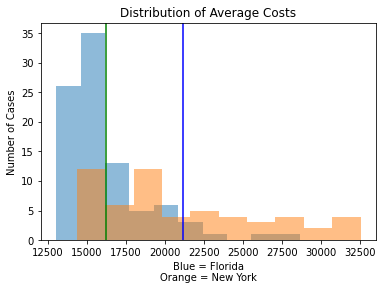

The statistics for Florida are: DescribeResult(nobs=91, minmax=(13039.63, 28667.63), mean=16254.773406593406, variance=7531461.507193822, skewness=1.932083184994845, kurtosis=4.616845237560891)
The statistics for New York are: DescribeResult(nobs=56, minmax=(14359.66, 32528.53), mean=21148.951964285716, variance=26442658.84152516, skewness=0.628374278725513, kurtosis=-0.7828957442159226)
Shaprio test for Florida data: (0.8146888017654419, 2.5033675132846156e-09)
Shapiro test for New York data: (0.9172089099884033, 0.0009325650753453374)

The Shapiro test and the visual both show that the Average Total Payments variables for New York is normal, but Florida is not.
These averages can be compared using a Kruskal Test. 



In [6]:
# Prefrom tests on 'Average Total Payments' normality
test_normal(pacemaker_fl, pacemaker_ny, ' Average Total Payments ')

# Results of Normality Test
'''
As we can see from our Shapiro tests, Florida is not normally distrubited, with a test statistic close to 1 which indicates normalness, but its p-value is
2.5 which is huge. Florida is almost certianly not normal. While New York has a  test statistic close to 1 and a very low p-value of .000009. We can conclude that this
data set is normal.

The data sets can be compared using a Kruskal test.
'''

print('\nThe Shapiro test and the visual both show that the Average Total Payments variables for New York is normal, but Florida is not.')
print('These averages can be compared using a Kruskal Test. \n')


Below we have the results of the Kruskal between Florida and New York, for the Average Total Payemtns, paid by the patients. Accoriding to the Kruskal tests, there is almost certainly a difference in the average patient payment between the two states, as our test statistic is 43.46 and our p values is much less than .00001. Therefore we can be almost certain that there is a significant difference. We then calculate what this difference could be, and we find that the average difference in patient payments between Florida and New York for a pacemaker installation is somewhere between 3434 and 6354, with a 95% confidence.

What we can conclude from this data is that while there is not a huge difference in what a patient pays for the pacemaker installation between New York and Florida, more patients pay lower prices in Florida than in New York.
 
For better visualization we have plotted the average patient payments for the two states and what range the difference would be in for both states. 

With this test complete we can reject our null hypothesis. We conclude that the althernative hypothesis is true, and that there is a significant difference.

KruskalResult(statistic=43.369484280198606, pvalue=4.532009560590829e-11)

Based of the relatively high test statistic from the Kruskal test, we can deduce that there is a significant difference.
The difference in means at the 95% confidence interval (two-tail) is between 3434.072417450861 and 6354.2846979337555.


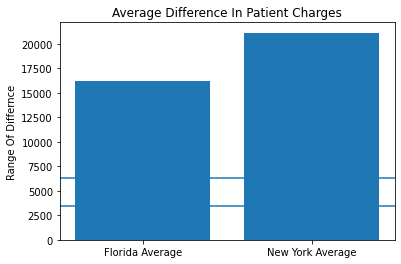

In [7]:
#Results of kruskal test on Florida and New York for Average Total Payments ('Patient Cost')
print(stats.kruskal(pacemaker_fl[' Average Total Payments '], pacemaker_ny[' Average Total Payments ']))
print('\nBased of the relatively high test statistic from the Kruskal test, we can deduce that there is a significant difference.')
ci_avg_patient = confidence_interval(pacemaker_fl[' Average Total Payments '], pacemaker_ny[' Average Total Payments '])
print("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_avg_patient[0])+" and "+str(ci_avg_patient[1])+".")
x_bar = ['Florida Average', 'New York Average']
bar_chart(x_bar,[pacemaker_fl[' Average Total Payments '].mean(), pacemaker_ny[' Average Total Payments '].mean()], 'Average Difference In Patient Charges', 'Range Of Differnce', ci_avg_patient)


Below we have the third test, on the 'Average Medicare Payments' or the charges paid by Medicare for the installation of permanent pacemakers, in the states of Florida and New York. We will test if there a differnce in average of what each state charges, on average, for the procedure.

Before the test can be preformed, we must first establish if the data sets are average or not. This is vital as it tells us what type of test needs to be preformed. This particular test shows again that Florida is not normally distrributed while New York is. It would seem that when it comes to medicare payments, Florida's distributions are quite skewed to lower values, as opposed to New York's which are more normally distributed. Florida in particular has a powerful skew towards lower medicare payments, with medicare paying as low as 11,000 while New York pays as low as 12,000 but could pay up to 31,000 much higher than Florida's max of 17,000.

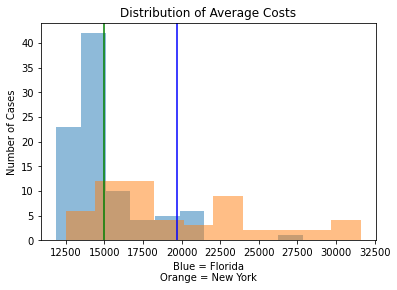

The statistics for Florida are: DescribeResult(nobs=91, minmax=(11887.89, 27856.0), mean=14977.501758241757, variance=6812385.458499095, skewness=2.050755025867118, kurtosis=5.623593037504435)
The statistics for New York are: DescribeResult(nobs=56, minmax=(12524.66, 31578.07), mean=19726.18392857143, variance=26113609.320787925, skewness=0.6513755927994469, kurtosis=-0.5639337770435975)
Shaprio test for Florida data: (0.798831045627594, 8.292179165536595e-10)
Shapiro test for New York data: (0.9308953285217285, 0.003234840463846922)

The Shaprio test and the visual both show that the Average Medicaire Payments variables for New York and Florida are both not normally distributed.
These averages can be compared using a Kruskal Test. 



In [8]:
# Preform tests on 'Average Medicare Payments' for normality
test_normal(pacemaker_fl, pacemaker_ny, 'Average Medicare Payments')

# Results of Normality Test
'''
As we can see from our Shapiro tests, Florida is not normally distrubited, with a test statistic much lower than 1 which is non-normal, and its p-value is
8 which agian, indicates non-normal distribution. Florida is almost certianly not normal. While New York has a  test statistic close to 1 and a very low p-value of .003. 
We can conclude that this data set is normal.

The data sets can be compared using a Kruskal test.
'''
print('\nThe Shaprio test and the visual both show that the Average Medicaire Payments variables for New York and Florida are both not normally distributed.')
print('These averages can be compared using a Kruskal Test. \n')

Below we have the results of the Kruskal between Florida and New York, for the Average Medicare Payments , paid by Medicare. Accoriding to the Kruskal tests, there is almost certainly a difference in the average patient payment between the two states, as our test statistic is 40.98 and a p value is much less than .00001. Therefore we can be almost certain that there is a significant difference. We then calculate what this difference could be, and we find that the average difference in patient payments between Florida and New York for a pacemaker installation is somewhere between 3306 and 6190, with a 95% confidence.

What we can conclude from this data is that while there is not a huge difference in what a medicare pays for the pacemaker installation between New York and Florida, more patients pay lower prices in Florida than in New York.
 
For better visualization we have plotted the average patient payments for the two states and what range the difference would be in for both states. 

With this test complete we can reject our null hypothesis. We conclude that the althernative hypothesis is true, and that there is a significant difference.

KruskalResult(statistic=40.98643875429593, pvalue=1.5328918096602943e-10)

Based of the relatively high test statistic from the Kruskal test, we can deduce that there is a significant difference.
The difference in means at the 95% confidence interval (two-tail) is between 3306.81495325147 and 6190.5493874078775.


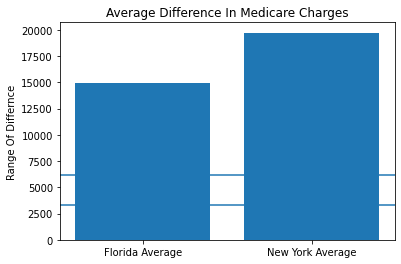

In [9]:
# Result of Kruskal test on Florida and New York for Average Medicare Payments ('Government Cost')
print(stats.kruskal(pacemaker_fl['Average Medicare Payments'], pacemaker_ny['Average Medicare Payments']))
print('\nBased of the relatively high test statistic from the Kruskal test, we can deduce that there is a significant difference.')
ci_avg_medicare = confidence_interval(pacemaker_fl['Average Medicare Payments'], pacemaker_ny['Average Medicare Payments'])
print("The difference in means at the 95% confidence interval (two-tail) is between "+str(ci_avg_medicare[0])+" and "+str(ci_avg_medicare[1])+".")
x_bar = ['Florida Average', 'New York Average']
bar_chart(x_bar,[pacemaker_fl['Average Medicare Payments'].mean(), pacemaker_ny['Average Medicare Payments'].mean()], 'Average Difference In Medicare Charges', 'Range Of Differnce', ci_avg_medicare)
